In [1]:
import nltk
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import gutenberg
from string import punctuation
import re
import numpy as np

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
from keras.layers import Dense, Reshape, Embedding, Concatenate, Dense, Input
from keras.models import Sequential, Model
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams


In [18]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [19]:
bible = gutenberg.sents('bible-kjv.txt')

In [20]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]

In [22]:
# remove punctuation and numbers from the text
remove_chars = punctuation + '0123456789'
normalized_bible = [[word.lower() for word in sent if word not in remove_chars] for sent in bible]

# join the tokens back into a string
normalized_bible_text = [' '.join(tok_sent) for tok_sent in normalized_bible]

# remove empty strings and lines with fewer than three words
filtered_bible_text = list(filter(None, normalized_bible_text))
filtered_bible_text = [tok_sent for tok_sent in filtered_bible_text if len(tok_sent.split()) > 2]

print('Total number of lines in the original corpus:', len(bible))
print('\nOriginal sample line:', bible[5])
print('\nProcessed sample line:', filtered_bible_text[5])

Total number of lines in the original corpus: 30103

Original sample line: ['And', 'the', 'Spirit', 'of', 'God', 'moved', 'upon', 'the', 'face', 'of', 'the', 'waters', '.']

Processed sample line: and the spirit of god moved upon the face of the waters


In [23]:
# create a tokenizer and fit it on the text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(filtered_bible_text)

# create mapping dictionaries for words to ids and ids to words
word_to_id = tokenizer.word_index
id_to_word = {v:k for k, v in word_to_id.items()}

# calculate the vocabulary size
vocab_size = len(word_to_id) + 1
embedding_size = 100

# convert the text to a list of word ids
word_ids = [[word_to_id[w] for w in text.text_to_word_sequence(doc)] for doc in filtered_bible_text]
print('Vocabulary size:', vocab_size)
print('Vocabulary sample:', list(word_to_id.items())[:10])

Vocabulary size: 12726
Vocabulary sample: [('the', 1), ('and', 2), ('of', 3), ('to', 4), ('that', 5), ('in', 6), ('he', 7), ('shall', 8), ('unto', 9), ('for', 10)]


#### Build and View sample skip grams

In [24]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in word_ids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id_to_word[pairs[i][0]], pairs[i][0],
          id_to_word[pairs[i][1]], pairs[i][1],
          labels[i]))

(askelon (6037), resheph (9794)) -> 0
(midian (1323), unweighed (9485)) -> 0
(midian (1323), shall (1)) -> 1
(askelon (6037), nahalol (9190)) -> 0
(midian (1323), askelon (6037)) -> 1
(name (50), drag (8099)) -> 0
(name (50), condition (9299)) -> 0
(shall (1), name (50)) -> 1
(askelon (6037), shall (1)) -> 1
(midian (1323), barefoot (5408)) -> 0


## Implementing the Skip Gram Model

In [28]:
# Define the input layers for the target and context words
target_word_input = Input(shape=(1,))
context_word_input = Input(shape=(1,))

# Build skip-gram architecture
target_word_model = Embedding(vocab_size, embedding_size,
                              embeddings_initializer="glorot_uniform")(target_word_input)
target_word_model = Reshape((embedding_size,))(target_word_model)

context_word_model = Embedding(vocab_size, embedding_size,
                               embeddings_initializer="glorot_uniform")(context_word_input)
context_word_model = Reshape((embedding_size,))(context_word_model)

# Concatenate the output of the target and context models
merged = Concatenate(axis=1)([target_word_model, context_word_model])

# Add a dense layer and sigmoid activation
output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(merged)

# Define the model
model = Model(inputs=[target_word_input, context_word_input], outputs=output)

# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# View model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 100)               1272600   ['input_1[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 100)               1272600   ['input_2[0][0]']             
                                                                                              

In [30]:
# # train the model on the skip-grams
# for epoch in range(1, 6):
#     total_loss = 0
#     for i, elem in enumerate(skip_grams):
#         skip_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
#         skip_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
#         labels = np.array(elem[1], dtype='int32')
#         X = [skip_first_elem, skip_second_elem]
#         Y = labels
#         if i % 10000 == 0:
#             print('Processed {} skip-gram pairs'.format(i))
#         total_loss += model.train_on_batch(X,Y)

#     print('Epoch: {} Loss: {}'.format(epoch, total_loss))

In [ ]:
from tqdm import tqdm

for epoch in range(1, 6):
    loss = 0
    for i, elem in tqdm(enumerate(skip_grams)):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)

    print('Epoch:', epoch, 'Loss:', loss)

1it [00:00,  9.42it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


10003it [06:36, 26.98it/s]

Processed 10000 (skip_first, skip_second, relevance) pairs


20003it [12:57, 21.21it/s]

Processed 20000 (skip_first, skip_second, relevance) pairs


29938it [19:19, 25.83it/s]


Epoch: 1 Loss: 1937.1354062261744


3it [00:00, 29.44it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


10001it [06:28, 20.74it/s]

Processed 10000 (skip_first, skip_second, relevance) pairs


20003it [12:56, 28.30it/s]

Processed 20000 (skip_first, skip_second, relevance) pairs


29938it [19:10, 26.03it/s]


Epoch: 2 Loss: 1823.150098079208


3it [00:00, 27.94it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


10003it [06:57, 25.84it/s]

Processed 10000 (skip_first, skip_second, relevance) pairs


20004it [13:09, 28.63it/s]

Processed 20000 (skip_first, skip_second, relevance) pairs


29938it [19:26, 25.65it/s]


Epoch: 3 Loss: 1774.7935777548446


3it [00:00, 27.18it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


10005it [06:17, 28.71it/s]

Processed 10000 (skip_first, skip_second, relevance) pairs


20002it [12:37, 20.56it/s]

Processed 20000 (skip_first, skip_second, relevance) pairs


29938it [19:07, 26.09it/s]


Epoch: 4 Loss: 1744.4383575246575


3it [00:00, 20.91it/s]

Processed 0 (skip_first, skip_second, relevance) pairs


10005it [06:29, 28.02it/s]

Processed 10000 (skip_first, skip_second, relevance) pairs


16960it [10:56, 20.27it/s]

In [ ]:
### Get Word embeddings

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

# get the embeddings for the words in the vocabulary
weights = model.layers[2].get_weights()[0]

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id_to_word[idx] for idx in distance_matrix[word_to_id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

print(similar_words)

(12726, 12726)
{'god': ['to', 'of', 'and', 'writer', 'that'], 'jesus': ['abishag', 'convey', 'compellest', 'rudiments', 'appearing'], 'noah': ['nicodemus', 'pharez', 'appearance', 'abba', 'bethany'], 'egypt': ['pathrusim', 'naphtuhim', 'lehabim', 'mentioned', 'revolters'], 'john': ['curious', 'spikenard', 'stink', 'couldest', 'mockers'], 'gospel': ['ziz', 'cliff', 'elishaphat', 'ambushments', 'controversies'], 'moses': ['dropped', '101', 'termed', 'stricken', 'loftiness'], 'famine': ['purim', 'covenanted', 'threescore', 'spikenard', 'highest']}


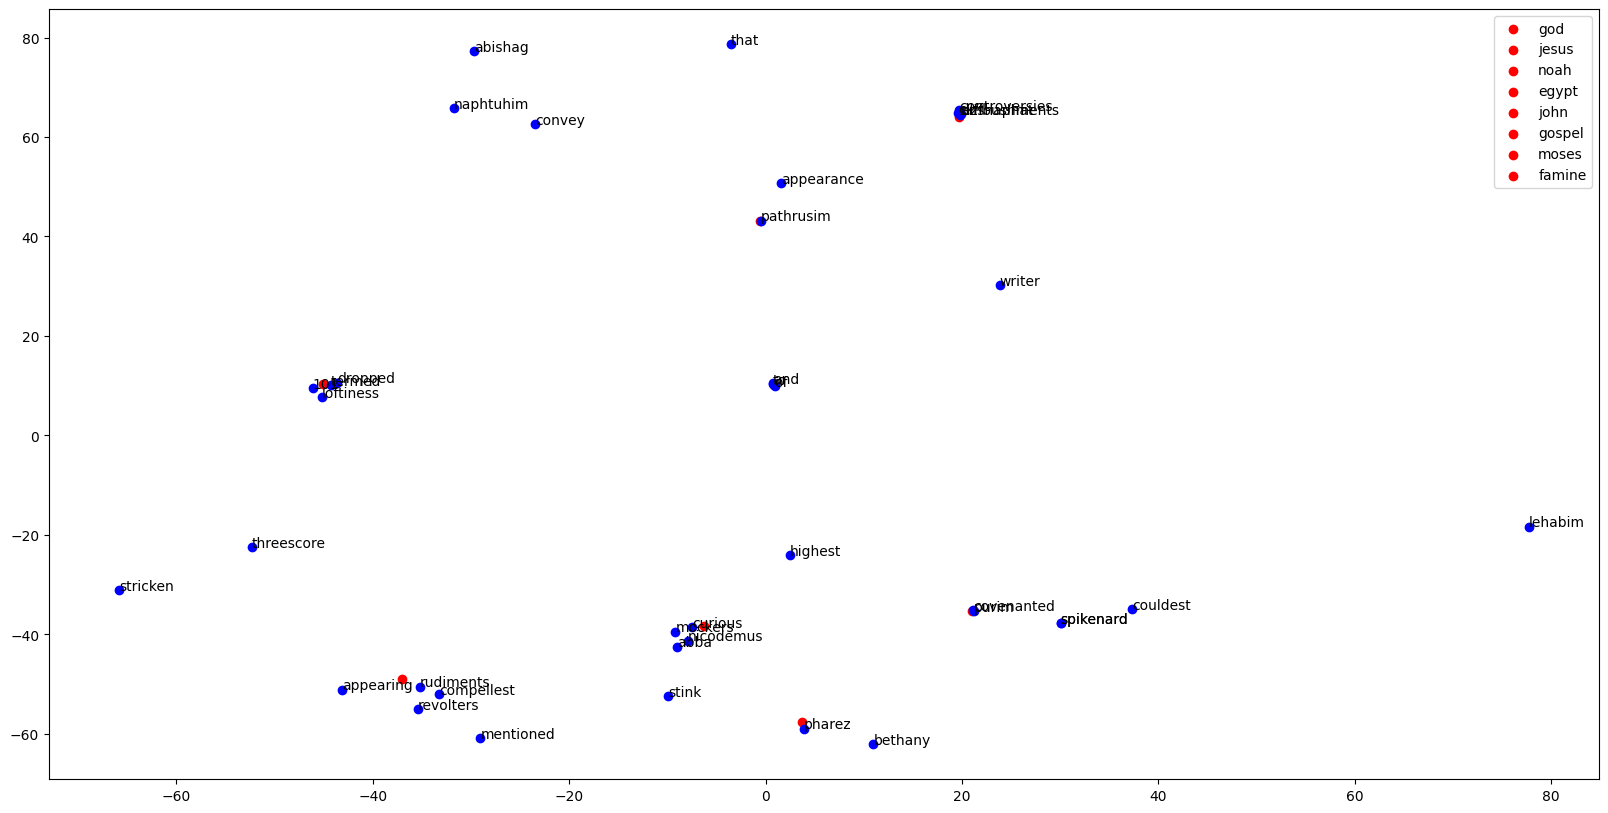

In [38]:
# reduce the dimensions of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(weights)

# create a list of the words in the vocabulary
words = [id_to_word[i] for i in range(1, vocab_size)]

# plot the similar words
fig, ax = plt.subplots(figsize=(20,10))
for word in similar_words:
    ax.scatter(vectors_2d[word_to_id[word]-1, 0], vectors_2d[word_to_id[word]-1, 1], c='red', label=word)
    for sim_word in similar_words[word]:
        ax.scatter(vectors_2d[word_to_id[sim_word]-1, 0], vectors_2d[word_to_id[sim_word]-1, 1], c='blue')
        ax.annotate(sim_word, (vectors_2d[word_to_id[sim_word]-1, 0], vectors_2d[word_to_id[sim_word]-1, 1]))
ax.legend()
plt.show()

# Use Genism

In [43]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in normalized_bible_text]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 30          # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, window=window_context, min_count=min_word_count,sample=sample)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

In [44]:
similar_words

{'god': ['christ', 'glory', 'lord', 'truth', 'world'],
 'jesus': ['prophet', 'word', 'john', 'esaias', 'spake'],
 'noah': ['kohath', 'sixteen', 'firepans', 'ham', 'shem'],
 'egypt': ['land', 'country', 'amorites', 'captivity', 'wilderness'],
 'john': ['daniel', 'paul', 'herod', 'baruch', 'peter'],
 'gospel': ['sufferings', 'earnest', 'preach', 'preaching', 'utterance'],
 'moses': ['joshua', 'audience', 'spake', 'regemmelech', 'sherezer'],
 'famine': ['pestilence', 'remaineth', 'noisome', 'briers', 'safely']}

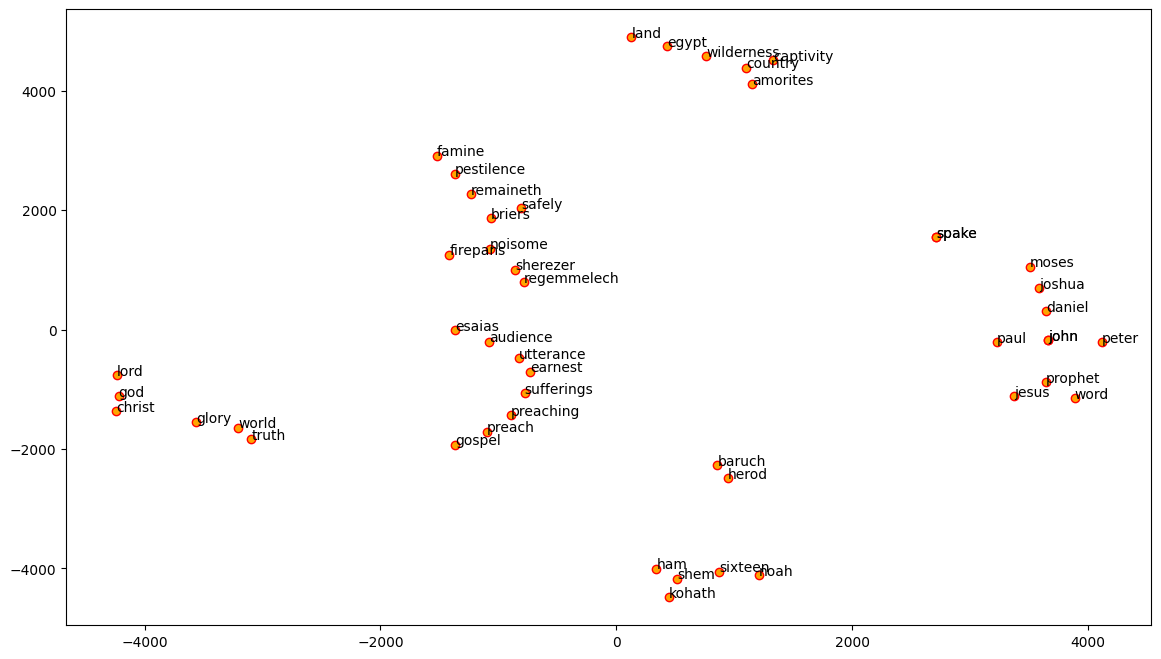

In [45]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [59]:
##########################################################################################################################################################################